## ARIMA (p,d,q) Prediction

###### 1. Import necessary packages

In [176]:
import pandas as pd
import numpy as np
import requests


from statsmodels.tsa.stattools import adfuller
from numpy import log

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,4), 'figure.dpi':100})
from fbprophet import Prophet

#
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

###### 2. Import the dataset

In [177]:
#import the csv file
oilPrices = pd.read_csv('./BrentOilPrices.csv')

oilPrices.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


###### 3. Cast Date Column to type date

In [178]:
oilPrices['Date'] = pd.to_datetime(oilPrices['Date'])
oilPrices['Date'].head()

0   1987-05-20
1   1987-05-21
2   1987-05-22
3   1987-05-25
4   1987-05-26
Name: Date, dtype: datetime64[ns]

###### 4. Fill missing values

In [179]:
# The data does not contain the values for Saturday and Sunday as the market is closed on weekends.
oilPrices.set_index('Date', inplace=True)
oilPrices = oilPrices.resample('D').ffill().reset_index()

In [180]:
# Make sure we have no null values
oilPrices.isnull().values.any()
# or this way
oilPrices.isnull().sum()

Date     0
Price    0
dtype: int64

###### 5. Split the data into year, month and week to explore trend in oil prices

In [181]:
oilPrices['year'] = oilPrices['Date'].dt.year
oilPrices['month'] = oilPrices['Date'].dt.month
oilPrices['week'] = oilPrices['Date'].dt.week

oilPrices.head()

,Date,Price,year,month,week
0,1987-05-20,18.63,1987,5,21
1,1987-05-21,18.45,1987,5,21
2,1987-05-22,18.55,1987,5,21
3,1987-05-23,18.55,1987,5,21
4,1987-05-24,18.55,1987,5,21


###### 6. Split the data into train and test 

In [182]:
train = oilPrices[(oilPrices['Date' ] > '2000-01-01') & (oilPrices['Date' ] <= '2018-12-31')]
test = oilPrices[oilPrices['Date' ] >= '2019-01-01']

###### 7. Visualize the Yearly data

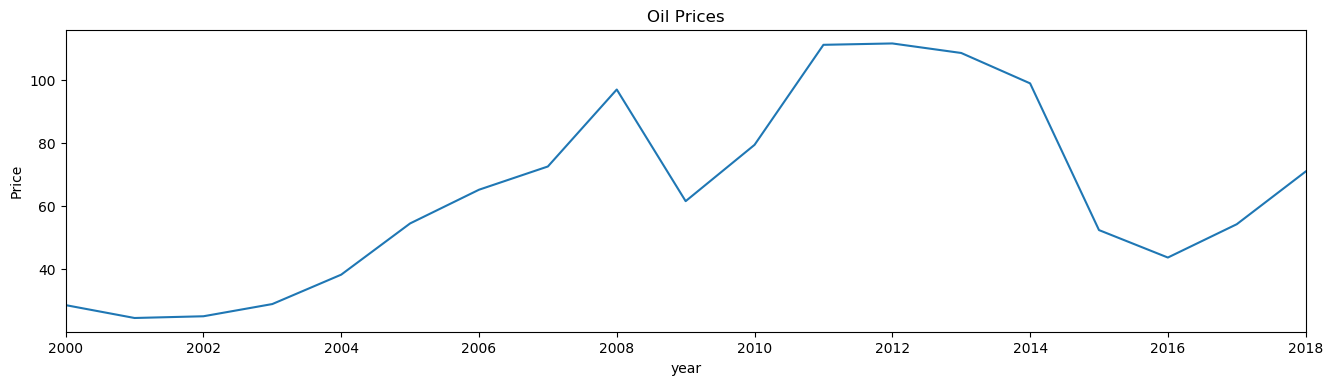

In [183]:
yearlyPrice = train.groupby(["year"])['Price'].mean()
plt.figure(figsize=(16,4))
plt.title('Oil Prices')
plt.xlabel('Year')
plt.ylabel('Price')
yearlyPrice.plot()
plt.show();

###### 8. ARIMA Model

In [184]:
# Prepare the data for the ARIMA estimator
# Convert to Time Series For ARIMA Estimator
series = pd.Series(data=train['Price'].to_numpy(), index=train['Date'])

In [185]:
# To predict time series with ARIMA, you need to set the values of three parameters (p,d,q):

# p: The order of the auto-regressive (AR) model (i.e., the number of lag observations)
# d: The degree of differencing.
# q: The order of the moving average (MA) model. 

###### 9. Order of differencing (d) in ARIMA model: 
######     Check the Stationarity

In [186]:
# ADF test for identifying the whether the time series set is stationary or not
# H0 hypothesis is 'Non Stationary'
result = adfuller(oilPrices['Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Sice we've got that p-value > 0.05 => there is not enough evidence to reject the null hypothesis:
# So our data is non stationary

ADF Statistic: -1.877847
p-value: 0.342553


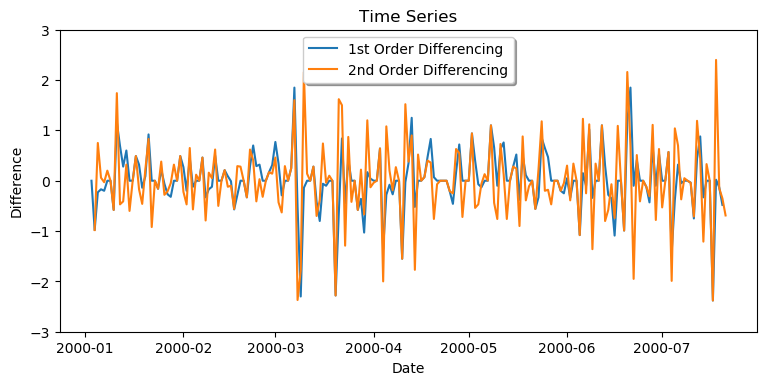

In [187]:
# Let's do one day differencing to see if this will make the data stationary: (for the first 100 rows)

daily_series_diff1 = series.diff(periods=1).dropna()
daily_series_diff2 = daily_series_diff1.diff(periods=1).dropna()

fig, ax = plt.subplots()
ax.plot(daily_series_diff1[0:200], label='1st Order Differencing')
ax.plot(daily_series_diff2[0:200], label='2nd Order Differencing')
plt.ylim([-3,3])

legend = ax.legend(loc='upper center', shadow=True)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.show()

In [188]:
#Number of differences required for a stationary series

y=series
# ADF Test       (Augmented Dickey–Fuller test)
print("ADF Test: ", ndiffs(y, test='adf'))

# KPSS Test      (Kwiatkowski–Phillips–Schmidt–Shin)
print("KPSS Test: ", ndiffs(y, test='kpss'))

# PP Test        (Phillips–Perron)
print("PP Test: ", ndiffs(y, test='pp'))

# Since from the all three tests we've got the same result which is d=1, 
# this can assure that the differencing value equlas 1 is the most correct.

ADF Test:  1
KPSS Test:  1
PP Test:  1


###### 10. AR(p)_Find the p

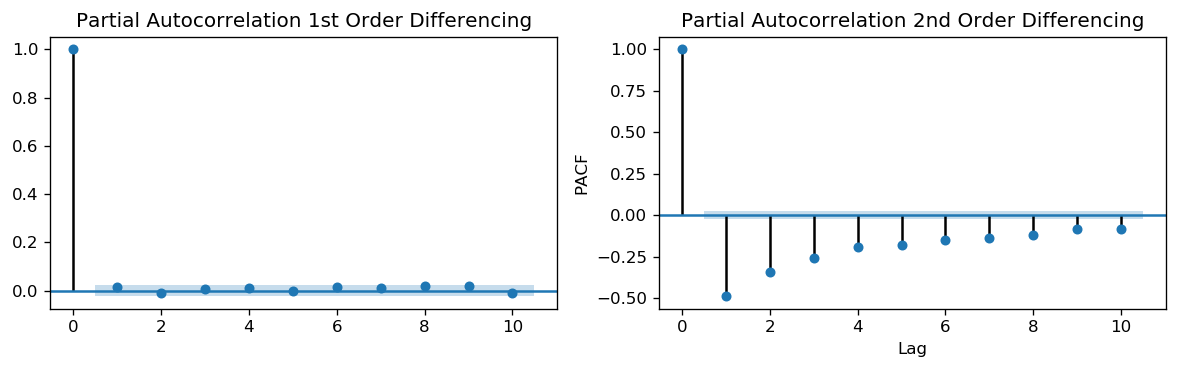

In [189]:
# In order to identify the reqired number of AR terms, let's look at the PACF plot:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
plot_pacf(daily_series_diff1, lags=10, ax=axes[0], title="Partial Autocorrelation 1st Order Differencing")
plot_pacf(daily_series_diff2, lags=10, ax=axes[1], title="Partial Autocorrelation 2nd Order Differencing")

plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

###### 11. MA(q)_Find q

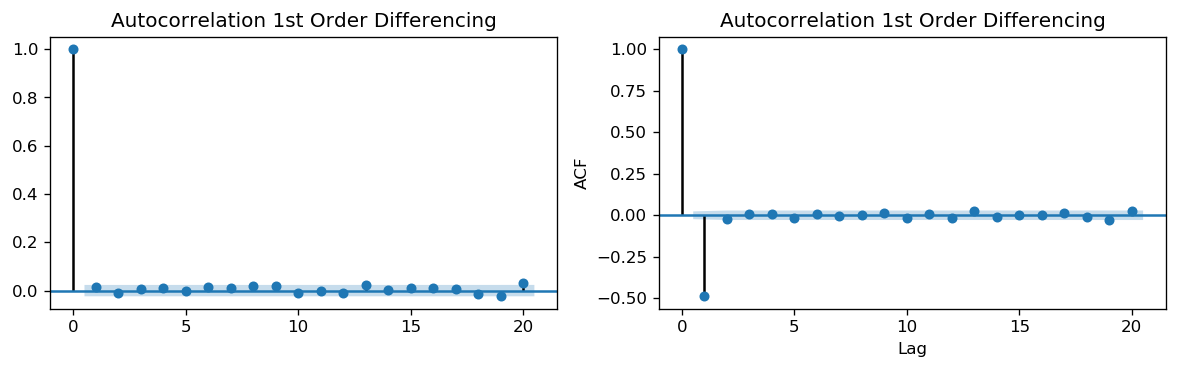

In [190]:
# In order to identify the reqired number of MA terms, let's look at the ACF plot:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
plot_acf(daily_series_diff1, lags=20, ax=axes[0], title="Autocorrelation 1st Order Differencing")
plot_acf(daily_series_diff2, lags=20, ax=axes[1], title="Autocorrelation 1st Order Differencing")

plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

###### 12. Final Model

In [191]:
import pmdarima as pm
model = pm.auto_arima(series, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Fit ARIMA: order=(1, 1, 1); AIC=21011.287, BIC=21038.666, Fit time=0.661 seconds
Fit ARIMA: order=(0, 1, 0); AIC=21009.243, BIC=21022.932, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=21009.873, BIC=21030.407, Fit time=0.036 seconds
Fit ARIMA: order=(0, 1, 1); AIC=21009.846, BIC=21030.380, Fit time=0.029 seconds
Total fit time: 0.749 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 6938
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -10502.621
Method:                           css   S.D. of innovations              1.099
Date:                Mon, 27 Apr 2020   AIC                          21009.243
Time:                        00:07:02   BIC                          21022.932
Sample:                             1   HQIC                         21013.962
                                                                              
              

In [192]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series, order=(1, 0, 1)).fit(transparams=False)
print(model.summary())

C:\Users\Lilit\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Lilit\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:221: RuntimeWarning:

overflow encountered in square

C:\Users\Lilit\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                ARMA Model Results                                
Dep. Variable:                      y   No. Observations:                     6939
Model:                     ARMA(1, 1)   Log Likelihood                  -10505.878
Method:                       css-mle   S.D. of innovations 261105776603909600.000
Date:                Mon, 27 Apr 2020   AIC                              21019.755
Time:                        00:07:03   BIC                              21047.135
Sample:                    01-02-2000   HQIC                             21029.194
                         - 12-31-2018                                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.4638     17.979      3.864      0.000      34.225     104.703
ar.L1.y        0.9992      0.000   2086.524      0.000       0.998       1.000
ma.L1.y        0.014

###### 13. Prediction

In [193]:
from statsmodels.tsa.arima_model import ARIMA
ARIMA_Predict = model.predict(start='1/1/2019', end='9/30/2019')
ARIMA_Predict.tail()

2019-09-26    54.067244
2019-09-27    54.078956
2019-09-28    54.090659
2019-09-29    54.102353
2019-09-30    54.114038
Freq: D, dtype: float64

###### 14. Evaluation

In [194]:
d={'ds':train['Date'],'y':train['Price']}
df_pred=pd.DataFrame(data=d)
model = Prophet(daily_seasonality=False)
model.fit(df_pred)

<Figure size 350x140 with 0 Axes>

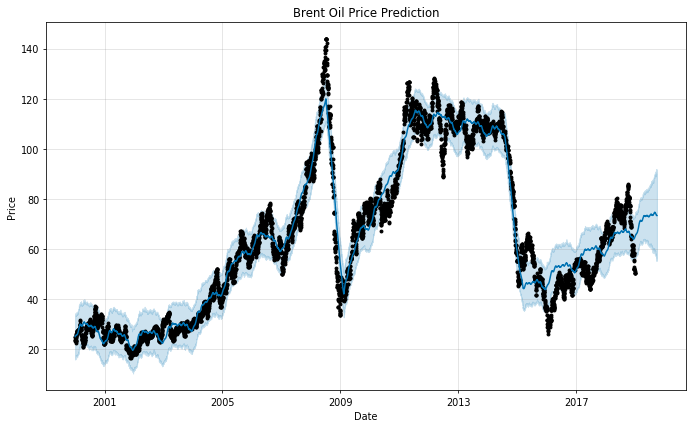

In [195]:
plt.rcParams.update({'figure.figsize':(8,3), 'figure.dpi':70})
future = model.make_future_dataframe(periods=273)
forecast = model.predict(future)
plt.figure(figsize=(5, 2))
model.plot(forecast, xlabel = 'Date', ylabel = 'Price')
plt.title('Brent Oil Price Prediction');

In [196]:
forecast2019 = forecast[(forecast['ds' ] >= '2019-01-01') & (forecast['ds' ] <= '9/30/2019')]

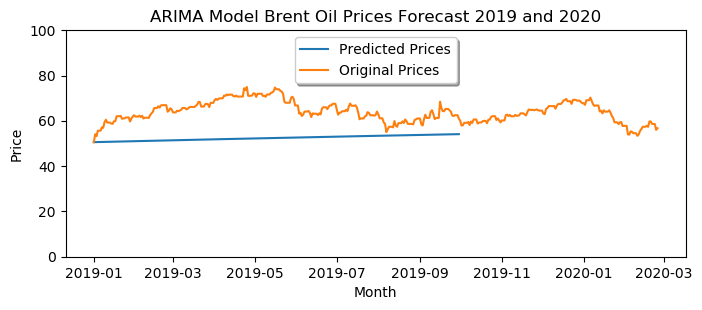

In [197]:
plt.rcParams.update({'figure.figsize':(8,3), 'figure.dpi':100})
fig, ax = plt.subplots()
ax.plot(forecast2019['ds'], ARIMA_Predict, label='Predicted Prices')
ax.plot(test['Date'], test['Price'], label='Original Prices')
plt.ylim([0,100])
legend = ax.legend(loc='upper center', shadow=True)
plt.title('ARIMA Model Brent Oil Prices Forecast 2019 and 2020')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()